# 4 Урок: Особенности работы с деревянными моделями. YETIRANK

**Импорт библиотек**

In [1]:
# Neural Networks
import torch
from torch import Tensor, FloatTensor
# Data
from catboost.datasets import msrank_10k
# Data preparation
from sklearn.preprocessing import StandardScaler
# Model
from sklearn.tree import DecisionTreeRegressor
# Hyperparameter tuning
import hyperopt as hopt
from hyperopt import hp
# Save model
import pickle
# Typing annotation
from typing import (
    Tuple, List, Dict, 
    Any, Union, Optional, 
    Callable, Iterable
)
# Tools
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import json
# Time management
from time import time
from datetime import datetime
# Visualization
import matplotlib.pyplot as plt
import plot_config
# Metrics
from metrics import compute_gain, dcg, ndcg, ndcg_k

## `RankNet`: Проблемы подхода

`RankNet` представляет собой реализацию _Pairwise_ подхода к обучению моделей ранжирования. Модели с этим подходом занимаются `упорядочиванием пар документов` или `минимизацией числа попарных ошибок`.

С одной стороны, перечисленные действия связаны с задачей ранжирования, однако легко привести пример, где минимизация попарных ошибок не улучшает метрики:

|$List_1$|$List_2$|
|:--:|:--:|
|$rel_1$|-|
|-|-|
|-|$rel_1$|
|-|$rel_2$|
|-|-|
|-|-|
|-|-|
|$rel_2$|-|

Пусть у нас имеется 2 списка из 8 документов для упорядочивания, причём в каждом списке только 2 релевантных документа.

Посчитаем _количество неупорядоченных пар_ и следующие метрики:
* `Average Precision`;
* `DCG`;
* `WTA` (Winner Takes All).



|Metric|$List_1$|$List_2$|
|:--|:--:|:--:|
|_Количество неупорядоченных пар_|6|<span style="background-color: green">4</span>|
|_AP_|5/2|<span style="background-color: red">5/12</span>|
|_DCG_|1.33|<span style="background-color: red">0.931</span>|
|_WTA_|1|<span style="background-color: red">0</span>|

Одной из причин, почему `RankNet` приводит к такой деградации метрик, является тот факт, что мы не учитываем важность документов: `некоторые из них куда важнее отранжировать в первую очередь`. В идеале нам бы хотелось, чтобы _вес документа зависел от того, как сильно изменится целевая метрика от перестановки конкретного объекта._

Возможные пути решения этой проблемы:

1. Перевзвешивать пары при расчёте функции потерь;
2. Изменять функцию потерь путём внесения информации о целевой метрике;
3. Менять градиент функции пропорционально целевой метрике.

Именно последний подход был предложен авторами [LambdaRank](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/lambdarank.pdf).

## `LambdaRank`

Вспомним ещё один факт о `RankNet`. Данная модель использует кросс-энтропию $C$ в качестве функции потерь,
$$
    C = -\sum_{x \in X} p(x) \cdot log(q(x))
$$

Также вспомним некоторые обозначения:
* $s_i, s_j -$ предсказания релевантности для $i$-ого, $j$-ого докуметов;
* $\sigma(x) -$ любая монотонно возрастающая, положительная функция, в нашем случае - `сигмоида`;
* $S_{ij} -$ новое трансформированное значение целевой переменной (target), получающееся в результате линейного преобразования старых значений: $\{0, 0.5, 1\}, \to \{-1, 0, 1\}$
$$\overline{P}_{ij} = \frac{1}{2}(1 + S_{ij})$$

Рассмотрим, как выглядят `градиенты функции потерь` $C$ `по предсказанным значениям релевантностей`$s_i$. Можно заметить, что значение совпадает для $i$-ого и $j$-ого документа с точностью до знака, что вполне логично: пара документов, которые неправильно отранжированны относительно друг друга, должны "тянуться" в разные стороны с одинаковой "силой" в силу симметричности:
$$
    \frac{\partial{C}}{\partial{s_i}} = \sigma \left( \frac{1}{2}(1 - S_{ij}) - \frac{1}{1 + e^{\sigma(s_i - s_j)}} \right) = -\frac{\partial{C}}{\partial{s_j}}
$$

Стоит заметить, что в формуле сверху рассматриваются градиенты относительно предсказаний $s$, а не весов самой модели RankNet. Поэтому давайте теперь рассмотрим полную формулу уже относительно весов нашей модели:
$$
    \frac{\partial{C}}{\partial{w_{k}}} = \frac{\partial{C}}{\partial {s_{i}}} \frac{\partial {s_{i}}}{\partial w_{k}} + \frac{\partial C}{\partial s_{j}} \frac{\partial s_{j}}{\partial w_{k}} = \sigma \left( \frac{1}{2} \left(1-S_{i j} \right) - \frac{1}{1+e^{\sigma \left( s_{i}-s_{j} \right) }} \right) \left( \frac{\partial s_{i}}{\partial w_{k}} - \frac{\partial s_{j}}{\partial w_{k}} \right)
$$

В этой формуле фигурирует уже знакомая нам дробь, которую мы рассматривали в формуле выше. Мы можем произвести замену, после чего вынести общую часть за скобки. В результате у нас получается произведение из двух множителей: в первых скобках у нас записано выражение, характеризующее `целевое изменение предсказаний` модели, а во вторых — `градиенты для изменения весов` модели.

Далее для простоты и краткости весь первый множитель этого произведения обозначим как $\lambda_{ij}$
$$
    \lambda_{ij} \equiv \frac {\partial C(s_i - s_j)}{s_i} = \sigma\left( \frac{1}{2} \left( 1 - S_{ij} \right) - \frac{1}{1 + e^{\sigma(s_i - s_j)}}\right)
$$

Тогда получим более лаконичнуб запись формулы для градиентов весов модели:
$$
    \sigma\left( \frac{1}{2} \left( 1 - S_{ij} \right) - \frac{1}{1 + e^{\sigma(s_i - s_j)}}\right) \left(\frac{\partial s_{i}}{\partial w_{k}} - \frac{\partial s_{j}}{\partial w_{k}} \right) = \lambda_{ij} \left(\frac{\partial s_{i}}{\partial w_{k}} - \frac{\partial s_{j}}{\partial w_{k}} \right)
$$

Далее, не ограничивая общности случая, переупорядочим все пары предсказанных релевантностей так, чтобы $i$-ый документ был всегда более релевантен чем $j$-ый документ. Тогда формула ещё сократится, т.к $S_{ij}=1$:
$$
    \lambda_{ij} = \frac{\partial C (s_i - s_j)}{\partial s_i} = -\sigma \left( \frac{1}{1 + e^{\sigma(s_i - s_j)}} \right)
$$

> А для чего собственно это было нужно?

Теперь можно заметить, что $\lambda_{ij}$ зависят только от наших предсказаний релевантностей $s_i, s_j$ и не зависят от функции потерь => мы больше не ограничены в выборе функции для $\lambda$. Она может быть сколь угодно сложной функцией. Это позволяет обойти трудности, связанные с сортировкой в большинстве метрик для задач ранжирования и $IR$ (_Information Retrieval_), и напрямую работать с их оптимизацией, а не ограничиваться корректным упорядочиванием пар.

Тогда формула для обновления весов модели получается следующей:
$$
    \delta w_k = \eta \sum_{\{i,j\} \in I} \left( \lambda_{ij}\frac{\partial{s_i}}{\partial w_k} - \lambda_{ij} \frac{\partial s_j}{\partial w_k} \right) = \eta \sum_{\{i,j\} \in I} \lambda_{i}\frac{\partial s_i}{\partial w_k}
$$

Здесь за $\lambda_i$ обозначена сумма по всем парам в датасете, в которые входит $i$-й элемент:

$\lambda_{i}=\sum_{j:\{i, j\} \in I} \lambda_{i j}-\sum_{j:\{j, i\} \in I} \lambda_{i j}$

Здесь очень просто провести аналогию с миром физики. Наш $i$-й документ можно представить как некоторую массу. Каждый $j$-й документ в первой сумме при вычислении $\lambda_i $— это по сути маленькая сила, которая подталкивает наш документ вверх или вниз в списке выдачи, повышая или понижая его предсказанное значение релевантности.

![https://storage.yandexcloud.net/klms-public/production/learning-content/3/10/161/535/3594/image.png](https://storage.yandexcloud.net/klms-public/production/learning-content/3/10/161/535/3594/image.png)

Сначала берём документы ниже нашего $i$-го в выдаче, т.е. где он является первым в паре (первая сумма в $\lambda_i$). Это будут "поднимающие" силы, которые тянут документ вверх. Затем наоборот — документы выше нашего $i$-го в выдаче (вторая сумма в $\lambda_i$). И это противодействующие силы, которые занижают наше предсказание релевантности. Сумма по всем таким объектам и есть суммарное воздействие на наш объект. Таким образом мы понимаем, как нужно изменять его оценку.

Если же посмотреть, как выбирают значение $\lambda_i$ в реальной жизни, то на практике значение уже знакомой нам $\lambda_i$ домножают на значение изменения целевой метрики, например nDCG (тут она немного модифицирована: вместо gain в числителе стоит степенная функция от него).

$$
    \mathrm{DCG}= \sum_{i} \dfrac{2^{\mathrm{rel}_{i}}-1}{\log _{2}(i+1)}
$$

$$
    \mathrm{nDCG}=\dfrac{\mathrm{DCG}}{\mathrm{IDCG}}
$$

Если же рассмотреть, как изменится метрика от перемены мест $i$-го и $j$-го документов, то мы получим следующую формулу:

$$
    \lambda_{ij}=N\left(\dfrac{1}{1+e^{s_{i}-s_{j}}}\right)\left(2^{\mathrm{rel}_{i}}-2^{\mathrm{rel}_{j}}\right)\left(\dfrac{1}{\log_2 (i+1)}-\dfrac{1}{\log_2 (j+1)}\right)
$$

Грубо говоря, чем больше прирост метрики от повышения или понижения позиции в ранжировании, тем больше это влияет на изменение предсказаний модели. В итоге более релевантные документы давят сверху, заставляя нерелевантные опускаться вниз, а менее релевантные давят снизу, заставляя всплывать подходящие документы.

Важно отметить, что расчёт градиентов идёт уже после сортировки документов по оценкам и градиенты текут как будто бы от нашей метрики, от nDCG или другой. То есть мы сначала берём все документы для запроса, прогоняем их через модель и получаем предсказания релевантности каждого отдельного объекта. До этого момента метод напоминает pointwise-подход. Далее мы берём все пары из этого ранжирования и пытаемся оценить изменение метрики при перестановке этих двух объектов из пары. После этого для каждого документа рассчитываем суммарную лямбду, которая говорит о том, куда нам лучше направить изменение предсказаний — вверх или вниз.

Трюк с вынесением $\lambda_i$ в выражении называется факторизацией. За счёт него мы получаем выигрыш в скорости работы, так как он позволяет нам за один прогон (за один forward-pass) по модели получить все предсказания для выдачи, подсчитать $\lambda_i$ и только после этого делать backward-pass (backpropagation), то есть операцию обратного распространения ошибки для расчёта градиентов. Этот шаг очень дорогой с точки зрения вычислительных мощностей. Если раньше для $n$ документов мы получали квадратичную зависимость от числа пар документов в датасете, то теперь мы используем пары для дешёвого расчёта изменения nDCG, а расчёт градиентов происходит один раз на каждый документ, на каждую $\lambda_i$. Это привело к очень значительному ускорению обучения RankNet. Фактически время обучения упало с почти квадратичного по количеству релевантных документов на запрос до почти линейного.

## `MART`

`Multiple Additive Regression Trees` - бустинг регрессионных деревьев.

Рассмотрим вкратце алгоритм построения регрессионных деревьев:

Пусть в некоторый момент построения мы имеем некоторую выборку объектов с их собственным набором признаков, представленных вектором. Для каждого признака:

1. Переберём все значения этого признака и будем строить разбиение объектов простым условием: значение признака $j$ меньше некоторого порогового числа $k$. Если это условие выполняется, то объект попадает в левое поддерево, если же оно ошибочно — в правое.
2. Затем по всем объектам левого поддерева L и правого R мы рассчитываем среднее значение предсказываемого значения $\mu$.
3. В каждом из двух множеств считаем среднеквадратичное отклонение (СКО). Общее СКО $S_j$ считаем как сумму СКО в левом и правом множествах.
4. Затем среди всех перебранных комбинаций разбиений мы выбираем разбиение с наименьшим значением этого среднеквадратичного отклонения $S_j$.

Функция ошибки может быть другой, но в классических деревьях для задачи регрессии используется именно СКО (_среднеквадратичное отклонение_).
$$
    S_j = \sum_{i \in L} (y_i - \mu_L)^2 + \sum_{i \in L} (y_i - \mu_R)^2
$$

Далее мы рекурсивно повторяем наш алгоритм для левого и правого поддерева, пока не достигнем некоторого критерия остановки, например _максимальной глубины дерева_, _максимального количества объектов в листе_ и т.д. Для самого последнего уровня дерева (или правильнее сказать _терминальных нод_), мы определяем наше предсказание как среднее всех объектов, попавших в лист дерева.

`Градиентный бустинг` - один из способов построения ансамбля $F_N(x)$ решающих деревьев. Для его построения мы используем ансамбль последовательно обучаемых деревьев $f_i(x)$, предсказание каждого из которых входит в итоговую сумму предсказаний c некоторым весом $\alpha_i$. Этот вес определяется каким-нибудь итеративным оптимизационным алгоритмом.
$$
    F_N(x) = \sum_{i=1}^{N} \alpha_i f_i(x)
$$

Пусть на каком-то этапе у нас есть некоторое количество построенных деревьев. 
> Как учить следующее?

На текущей итерации строится $m$-ое дерево, когда на вход приходит суммарное предсказание $m-1$ предыдущих деревьев.

Теперь необходимо понять, какие ответы должны получиться на следующем дереве, чтобы в сумме с текущими ответами наша ошибка минимизировалась. В этом нам поможет _антиградиент_, т.к. решается задача минимизации. Мы хотим понять, как нам нужно изменить наше предсказание на объекте, чтобы минимизировать некоторый функционал $L$ от целевой переменной $y_i$ и текущего предсказания $F_{m-1}(x_i)$. То есть по сути это как раз ровно такая производная, что указана в формуле ниже — наш антиградиент.

$\bar{y}_{i}=-\left[\dfrac{\partial L\left(y_{i}, F\left(x_{i}\right)\right.}{\partial F\left(x_{i}\right)}\right]_{F(x)=F_{m-1}(x)}$

Такое новое дерево должно корректировать уже имеющиеся предсказания, и потому ему на вход в качестве целевых переменных, в качестве меток, приходят не наши базовые $y_i$ из выборки, а так называемые "невязки" или остатки (сколько нам не хватает для того, чтобы дать точное предсказание).

**Обратим внимание, что по сути это в точности наши $\lambda_i$ из LambdaRank, из метода для задачи ранжирования!**

$\lambda_{i} \equiv \sum_{j \in P_{i}} \dfrac{\partial C\left(s_{i}, s_{j}\right)}{\partial s_{i}}$

Естественным образом напрашивается объединение алгоритма LambdaRank и MART. Получается [LambdaMART](https://www.notion.so/learning/3/module/10/lesson/161/535/3596/)

## `LambdaMART`

Рассмотрим получившийся алгоритм Lambda[S]MART:

![Псевдокод алгоритма LambdaSMART](https://storage.yandexcloud.net/klms-public/production/learning-content/3/10/161/535/3596/image.png)

Псевдокод алгоритма Lambda[S]MART

- [2] Итак, сначала для всех $N$ объектов выборки получим входные предсказания. Это могут быть предсказания, например, ListNet или RankNet.
- [4] Затем мы начинаем цикл постройки $M$  деревьев.
- [5-6] Снова пройдёмся по всем объектам $N$ и для каждого посчитаем наш градиент. Если при построении классического градиентного бустинга мы использовали производную от функции MSE, которая равняется простой разности величин $y_i - f(x_i)$, то теперь мы считаем $\lambda_i$, как это делалось в LambdaRank. На основе текущих предсказаний мы строим ранжирование, определяем прирост метрик от перестановки, рассматриваем все пары в выдаче и суммируем, чтобы получить финальное значение. Напомним, что смысл этой $\lambda_i$ в том, что она указывает, как и в каком направлении нужно изменить наше предсказание, чтобы оптимизировать функцию ошибки или улучшить метрики.
- [7] Тут же рассчитывается $w_i$ — вторая производная, используемая для расчёта веса при суммировании. Её мы опустим, так как к ранжированию это не имеет никакого отношения, это компонента градиентного бустинга.
- [9] После того, как мы посчитали все $\lambda_i$, мы их объявляем нашими целевыми переменными для построения нового дерева, и строим его для наших объектов $\{x_i\}_{i=1}^N$ с целью предсказать $\lambda_i$, то есть новый $y_i$. Если в классическом градиентном бустинге в задаче регрессии мы брали разницу целевого и предсказанного значения, то сейчас мы пытаемся обучиться, используя $\lambda_i$ в качестве целевой переменной, которая при построении каждого нового дерева меняется, так как меняются предсказанные значения. Эта замена производных работает потому, что и $\lambda_i$, и разность указывают нам на то, как именно нужно поменять предсказываемые релевантности, чтобы уменьшить значение функции потерь.
- [10] Далее рассчитываем длину нашего градиентного шага, которая уникальна для каждого отдельного листа. Это не learning rate, это отдельный коэффициент. Он вычисляется с помощью метода Ньютона (детали мы опустим). Суть в том, что просто подбирается такое число, при умножении на которое предсказаний нового построенного дерева мы, насколько это возможно, минимизируем функцию потерь.
- [11] И наконец, мы обновляем наш ансамбль, добавляя к уже полученным скорам предсказания нового дерева. При этом здесь есть и learning rate, который обозначен как $v$ и обычно одинаков для всех деревьев в бустинге, и наш коэффициент, рассчитанный для каждого отдельного листа каждого отдельного дерева.

## `YetiRank`

Ссылка на оригинальную статью для интересующихся: [тут](http://proceedings.mlr.press/v14/gulin11a/gulin11a.pdf)

Сейчас YetiRank широко используется, например, в CatBoost’е — реализации градиентного бустинга от Yandex. Разработан сам метод тоже сотрудниками Яндекса. На одной из страниц документации к CatBoost’у указывается, что он один из самых качественных с точки зрения средних метрик на разных датасетах. Однако он достаточно медленный. Интересно, что именно YetiRank выиграл те же соревнования, что и LambdaMART, но годом позже — в 2011 году.

Итак, в качестве основной функции потерь используется та же самая формула, что была и в RankNet при pairwise-подходе, однако каждая пара дополнительно взвешивается множителем $w_{ij}$. Авторы также упоминают возможность добавления уже изученной нами $\lambda_{i}$ при расчёте градиентов, но мы абстрагируемся от этого и сделаем упор на ключевых изменениях.

$\mathbb{L}=-\sum_{(i, j)} w_{i j} \log \dfrac{e^{x_{i}}}{e^{x_{i}}+e^{x_{j}}}$

$w_{ij} = N_{ij} c(l_i, l_j)$

Каждый из весов уникален для конкретной пары документов при обучении и состоит из двух компонент, двух сомножителей. Первый множитель $N_{ij}$ помогает нам при обучении понять, насколько данная пара важна для ранжирования. Второй множитель — некоторая функция отметок релевантности $l_i$ и $l_j$ из разметки. Она показывает нам, насколько легко эти метки перепутать.

Давайте внимательно рассмотрим первую составляющую. Как уже обсуждалось, не все объекты важны при ранжировании, и иногда лучше определённый документ поднимать со дна выдачи. Для оценки важности предлагается на очередной итерации бустинга брать предсказываемые значения $x_i$  и добавлять к ним шум по указанной ниже формуле:

$\hat{x}_{i}=x_{i}+\log \dfrac{r_{i}}{1-r_{i}}$

Этот шум может быть положительным или отрицательным, а $r_i$ принимает значение от $0$ до $1$ из семплируется из равномерного распределения. Затем производится реранжирование согласно предсказаниям с шумом, за счет чего мы добиваемся некоторого перемешивания.

Далее мы идём сверху вниз, рассматриваем каждые два подряд идущих документа и увеличиваем суммарный вес этой пары на величину метрики MRR, которая считается согласно указанной ниже формуле:

$N_{ij} = \dfrac{1}{n} \sum_{t=1}^{n} \dfrac{1}{{index}_{t}(\min (i, j))}$

Об этой метрике мы говорили на второй лекции. Напомним, что по сути это просто величина, обратная рангу. В паре мы берём самый верхний документ, поэтому нам нужен минимальный индекс, что и записано в знаменателе. После переупорядочивания выборки с шумом в предсказаниях мы берём первый и второй документы и вес этой пары увеличиваем на единицу, так как среднеобратный ранг будет $1$. Потом мы берём второй и третий документы и получаем вес пары $1/2$. Выходит, что у нас есть только веса для тех пар, которые попадались при перемешивании последовательно. Веса остальных пар равны нулю.

Процедура внесения шума, перемешивания и расчёта веса повторяется 100 раз, каждый раз у нас получается другая перестановка. Чем выше каждый раз попадает документ, тем больше его вес, и наоборот. Если у нас за эти 100 попыток ни разу не шли подряд какие-либо два документа, а в разметке в датасете у нас для них есть оценка релевантности, то эта пара не будет использоваться при обучении на данной итерации, так как её вес нулевой. Понятно, что в самом начале обучения вес $N_{ij}$ практически ни на что не влияет, и он вообще случайный. Однако он начинает играть существенную роль, когда в бустинге уже есть несколько построенных деревьев, и наши предсказания обретают смысл, а получаемое ранжирование неслучайно.

Другая составляющая весов в функции потерь — это вот такая хитрая формула:

$c \left( l_{i}, l_{j} \right) = \sum_{u, v} 1_{ u \gt v} p \left( u | l_{i} \right) p \left( v | l_{j} \right)$

Она помогает нам уделять больше внимания тем парам объектов, у которых нет неопределённости в проставленной оценке релевантности, то есть во входных данных. Здесь $u$ и $v$ — это конкретные оценки для $i$-го и $j$-го документов, например от $1$ до $5$, где $1$ означает нерелевантный мусор, а $5$ — идеальное соответствие.

Далее мы пробегаемся по всем возможным комбинациям этих оценок и берём только такие, где релевантность первого документа выше, чем второго, так как у нас в датасете изначально сделан тот же трюк, что использовался в LambdaRANK с перестановкой пар. Для этих комбинаций происходит умножение единицы на две вероятности, характеризующие возможность того, что оценка релевантности в датасете на самом деле выставлена неправильно (люди, размечающие данные, не идеальны и могут ошибаться). Стоит также отметить, что этот множитель у веса пары, а именно функция $c$ от лейблов $l_i$ и $l_j$ не зависит от текущей модели и может быть предрассчитана, так как мы используем только метки из датасета, но не предсказания.

Последнее, что хочется обсудить сегодня — как определять “истинные” значения меток в разметке, которые были упомянуты выше, а также как строить такую матрицу на основе своих данных. На самом деле метки не являются истинными, это просто наше предположение о том, какими они должны быть. Для того чтобы выдвинуть такое предположение, все документы в уже векторизованном виде разобъём по так называемым “бакетам”, то есть просто на несколько кластеров. Объединяем объекты в один кластер, если расстояние от текущего $i$-го объекта не больше, чем некоторый маленький $\epsilon$ до всех других объектов кластера. В идеальном случае у нас в один "бакет" должны попадать объекты с одинаковым набором признаков, то есть идентичные документы, но если говорить в целом, то они просто должны быть максимально похожи.

Для документов из "бакета" мы можем посмотреть на распределение меток релевантности в разметке, и определить превалирующую составляющую. В статье предлагается просто случайно брать метку из этого кластера, взвешивая вероятность взятия на количество объектов с этой меткой в "бакете". Если все объекты в кластере максимально похожих объектов имеют одинаковую метку, то это значит, что никакой неопределённости в этом кластере нет. А вот если из 20 объектов 17 имеют отметку “хорошее соответствие”, а 3 — “идеальное” (и это при том, что с точки зрения признакового описания эти объекты максимально похожи), то скорее всего тут возникла какая-то путаница в разметке. А для построения самой confusion матрицы нам подойдёт какой-нибудь итеративный метод, оптимизирующий функцию правдоподобия, то есть можно просто пытаться сделать значения в матрице максимально похожими на ту картину, что мы наблюдаем в "бакетах".

# **>** **Резюме**

- На примере мы разобрались, почему не всегда нужно оптимизировать количество неупорядоченных пар и чем это может обернуться.
- Далее мы решили эту проблему с помощью подмены градиентов, реализованной в методе LambdaRank. Новые градиенты зависят напрямую от изменения целевой метрики, а не от функции потерь. Приём подмены градиентов, как оказалось, можно и нужно использовать в деревянных моделях, а именно в градиентном бустинге. На очередной итерации обучения нового дерева нам нужно в качестве целевых значений указать  $\lambda$, и тогда модель покажет хорошее качество в задаче ранжирования, вобрав в себя плюсы разобранных выше подходов. Однако и этот подход не лишён минусов, и для их разрешения мы вводим в функцию потерь веса, зависящие от важности объекта и от качества нашей разметки.
- Всё это предлагает нам такой метод, как YetiRank.

## Практика

### Пример

Посмотрим на работу коэффициентов $\lambda_{ij}$ на практике. Сгенерируем очень плохие предсказания релевантности и попробуем их скорректировать с помощью коэффициентов.

$$
    \lambda = \left(\frac{1}{2} * (1 - S_{ij}) - \frac {1} {1 + e^{s_i - s_j}}\right) |\Delta_{nDCG}|
$$
$$
    \Delta_{nDCG} = \frac {1} {IdealDCG} (2^i - 2^j) \left(\frac {1} {log_2(1+i)} - \frac {1} {log_2(1+j)}\right),
$$
$$
    N = \frac{1}{IdealDCG}
    
$$

In [2]:
y_true = torch.FloatTensor([5, 3, 2, 5, 1, 1]).reshape(-1, 1)
# Специально предсказываем вторую "5" и последнюю "1" очень плохо.
y_pred = torch.FloatTensor([3.0, -0.5, -0.1, -2.7, 0.001, 2]).reshape(-1, 1) 

In [3]:
def compute_labels_in_batch(y_true):
    """Compute labels value in batch of data: 
        S_ij = 1 if rel_i > rel_j else -1 (rel_i < rel_j).

    Parameters
    ----------
    y_true : `FloatTensor`
        True relevance labels.

    Returns
    -------
    Sij : `FloatTensor`
        Matrix of label's relevances pairs relation.
    """
    # Relevances difference everyone with everyone
    rel_diff = y_true - y_true.T
    # 1 here - more relevante
    pos_pairs = (rel_diff > 0).type(torch.float32)
    # 1 here - less relevante
    neg_pairs = (rel_diff < 0).type(torch.float32)
    Sij = pos_pairs - neg_pairs
    return Sij


def compute_gain_diff(y_true, gain_scheme):
    """Computes the gain difference between each i and j pairs of y_true.

    Parameters:
    -----------
    y_true : `FloatTensor`
        True relevance labels.
    gain_scheme : `str`
        Gain scheme. Allowed values = ['const', 'exp2']
            * const : gain = rank;
            * exp2  : gain = 2^rank - 1.

    Returns
    -------
    gain_diff : `FloatTensor`
        Matrix of gain difference between each i and j pairs of y_true.
    """
    if gain_scheme == "exp2":
        gain_diff = torch.pow(2.0, y_true) - torch.pow(2.0, y_true.T)
    elif gain_scheme == "const":
        gain_diff = y_true - y_true.T
    else:
        raise ValueError(f"{gain_scheme} method not supported")
    return gain_diff


def compute_lambdas(y_true: FloatTensor, 
                    y_pred: FloatTensor, 
                    gain_scheme: str = 'exp2') -> FloatTensor:
    """Computes the lambdas for the true and predicted relevance values
    by formula:
        ( 1/2 * (1 - S_{ij}) - 1/(1 + exp^(s_i - s_j)) *
        | 1/IdealDCG * (2^i - 2^j) * (1/log2(1+i) - 1/log2(1+j)) |

    Parameters
    ----------
    y_true : `FloatTensor`
        True relevance labels.
    y_pred : `FloatTensor`
        Predicted relevance values.
    gain_scheme : `str`
        Default='exp2'
        Gain scheme. Allowed values = ['const', 'exp2']
            * const : gain = rank;
            * exp2  : gain = 2^rank - 1.

    Returns
    -------
    lambdas_update : `FloatTensor`
        Lambdas values to update y_pred.
    """
    # Norm coeff
    ideal_dcg = dcg(y_true, y_true, gain_scheme=gain_scheme)
    N = 1 / ideal_dcg
    # Sort documents by relevances
    _, rank_order = torch.sort(y_true, descending=True, dim=0)
    # i,j \in \N from 1
    rank_order += 1

    with torch.no_grad():
        # Compute 1 + exp^(s_i - s_j) for y_pred
        pairs_scores_diff = 1.0 + torch.exp((y_pred - y_pred.t()))
        # Compute S_ij = 1 if rel_i > rel_j else -1
        Sij = compute_labels_in_batch(y_true)
        # Compute gain difference (i - j) or (2^i - 2^j)
        gain_diff = compute_gain_diff(y_true, gain_scheme)
        # Compute position change in denominators (1/log2(1+i) - 1/log2(1+j) 
        denominators_diff = (1.0 / torch.log2(rank_order + 1.0)) - (1.0 / torch.log2(rank_order.t() + 1.0))
        # Delta nDCG
        delta_ndcg = torch.abs(N * gain_diff * denominators_diff)
        # Compute lambdas
        lambda_update = (0.5 * (1 - Sij) - 1 / pairs_scores_diff) * delta_ndcg
        # Sum lambdas over j axis
        lambda_update = torch.sum(lambda_update, dim=1, keepdim=True)
    return lambda_update

In [4]:
compute_lambdas(y_true, y_pred, 'exp2')

tensor([[-0.1232],
        [ 0.0150],
        [ 0.0640],
        [-0.2205],
        [ 0.0798],
        [ 0.1849]])

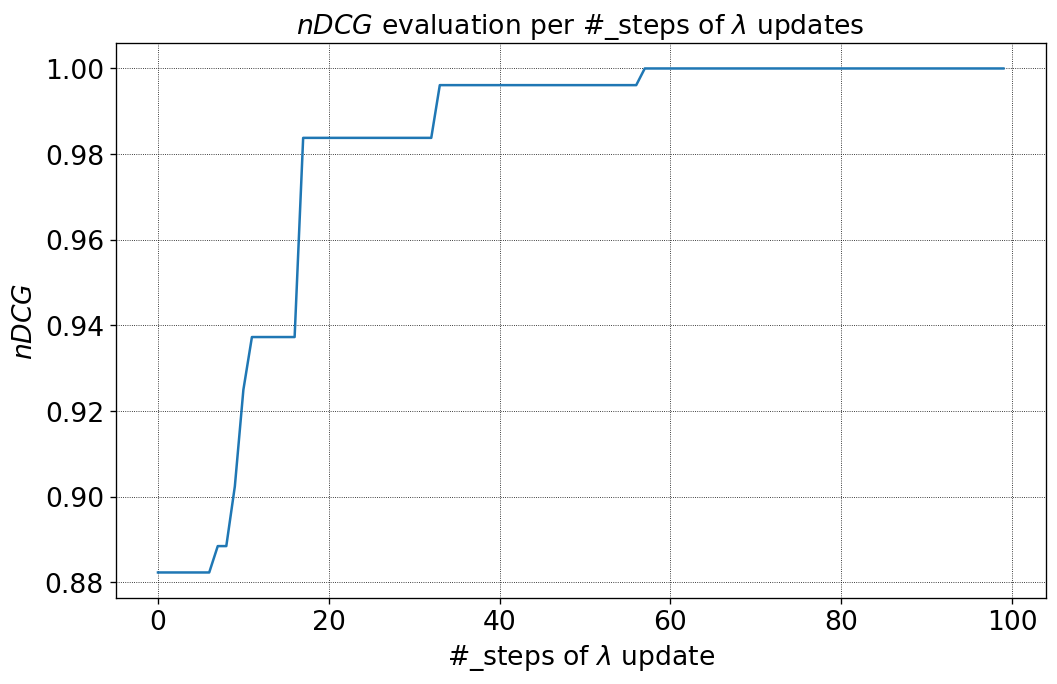

In [5]:
scores = []
steps = 100

for _ in range(steps):
    lambda_update = compute_lambdas(y_true, y_pred, gain_scheme='exp2')
    y_pred -= lambda_update
    scores.append(ndcg(y_true, y_pred))


plt.plot(range(steps), scores)
plt.grid()
plt.xlabel('#_steps of $\lambda$ update')
plt.ylabel('$nDCG$')
plt.title("$nDCG$ evaluation per #_steps of $\lambda$ updates");

### Пример 2

Реализуем _градиентный бустинг_ на основе вычисления $\lambda$, используя сокращённый датасет [msrank_10k](https://catboost.ai/en/docs/concepts/python-reference_datasets_msrank_10k)

В качестве базового алгоритма для бустинга будем использовать `DecisionTreeRegressor` из библиотеки `sklearn`. Целевыми метками, на которые обучается каждое дерево, вместо типичных для бустинга ошибок (невязок), будут $\lambda$-значения.

#### Параметры класса

* `n_estimators` — количество деревьев, которые будут строиться в рамках бустинга;
* `lr` — _Learning Rate_, коэффициент, на который умножаются предсказания каждого нового дерева в алгоритме (каждое дерево учится предсказывать значение $\lambda$, но не факт, что добавление к текущим предсказаниям такого значения даст оптимум, поэтому весь “путь” оптимизации разбивается на маленькие шаги);
* `subsample` — доля объектов от выборки, на которых обучается каждое дерево (доля одинакова для всех деревьев, но сама подвыборка генерируется на каждом шаге отдельно).
* `colsample_bytree` — доля признаков от выборки, на которых обучается каждое дерево (доля одинакова для всех деревьев, но сама подвыборка генерируется на каждом шаге отдельно).

Совокупность двух вышеуказанных параметров позволяет реализовать [метод случайных подпространств](https://en.wikipedia.org/wiki/Random_subspace_method#Algorithm). Понятно, что для применения деревьев (получения предсказания) нужно хранить индексы использованных признаков (но не объектов).

* `max_depth` и `min_samples_leaf` — параметры `DecisionTreeRegressor`, отвечающие за глубину построения дерева и минимальное количество в терминальных (финальных) листьях дерева соответственно. 

In [6]:
class GBDTLambdaRank:
    def __init__(self,
                 n_estimators: int,
                 lr: float,
                 subsample: float,
                 colsample_bytree: float,
                 max_depth: int,
                 min_samples_leaf: int,
                 metric_func: Callable[[torch.FloatTensor, torch.FloatTensor], float],
                 metric_params: Dict[str, Any]=None):
        torch.manual_seed(0)
        np.random.seed(0)

        self._prepare_data()

        self.metric_func = metric_func
        if 'metric_name' in metric_params:
            self.metric_name = deepcopy(metric_params['metric_name'])
            del metric_params['metric_name']
        else:
            self.metric_name = self.metric_func.__name__
        if 'top_k' in metric_params:
            self.top_k = metric_params['top_k']
        
        self.metric_params = metric_params
        # Trees parameters
        self.n_estimators = n_estimators
        self.lr = lr
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        # Model parameters
        self.trees = []
        self.tree_features = []
        self.best_metric_value = 0
        self.prune_ind = -1
        # Data parameters
        self.n_samples = round(self.subsample * self.X_train.shape[0])
        self.n_features = round(self.colsample_bytree * self.X_train.shape[1])


    def _get_data(self) -> List[np.ndarray]:
        train_df, test_df = msrank_10k()

        # [0, 1] column index = target/queryGroupID columns
        X_train = train_df.drop([0, 1], axis=1).values
        y_train = train_df[0].values
        query_ids_train = train_df[1].values.astype(int)

        X_test = test_df.drop([0, 1], axis=1).values
        y_test = test_df[0].values
        query_ids_test = test_df[1].values.astype(int)

        return [X_train, y_train, query_ids_train, 
                X_test, y_test, query_ids_test]


    def _scale_features_by_query_groups(self, 
                                        features: np.ndarray, 
                                        query_ids: np.ndarray) -> np.ndarray:
        for query_id in np.unique(query_ids):
            mask = query_id == query_ids
            scaler = StandardScaler()
            features[mask] = scaler.fit_transform(features[mask])
        return features


    def _prepare_data(self) -> None:
        (X_train, y_train, self.query_ids_train,
            X_test, y_test, self.query_ids_test) = self._get_data()
        self.query_ids_train_unique = np.unique(self.query_ids_train)
        self.query_ids_test_unique = np.unique(self.query_ids_test)

        X_train = self._scale_features_by_query_groups(X_train, self.query_ids_train)
        X_test = self._scale_features_by_query_groups(X_test, self.query_ids_train)
        
        self.X_train = torch.FloatTensor(X_train)
        self.X_test = torch.FloatTensor(X_test)
        self.y_train = torch.FloatTensor(y_train).unsqueeze(1)
        self.y_test = torch.FloatTensor(y_test).unsqueeze(1)


    def _compute_labels_in_batch(self, y_true: FloatTensor) -> FloatTensor:
        """Compute labels value in batch of data: 
            S_ij = 1 if rel_i > rel_j else -1 (rel_i < rel_j).

        Parameters
        ----------
        y_true : `FloatTensor`
            True relevance labels.

        Returns
        -------
        Sij : `FloatTensor`
            Matrix of label's relevances pairs relation.
        """
        # Relevances difference everyone with everyone
        rel_diff = y_true - y_true.T
        # 1 here - more relevante
        pos_pairs = (rel_diff > 0).type(torch.float32)
        # 1 here - less relevante
        neg_pairs = (rel_diff < 0).type(torch.float32)
        Sij = pos_pairs - neg_pairs
        return Sij


    def _compute_gain_diff(self, y_true: FloatTensor, 
                           gain_scheme: str) -> FloatTensor:
        """Computes the gain difference between each i and j pairs of y_true.

        Parameters:
        -----------
        y_true : `FloatTensor`
            True relevance labels.
        gain_scheme : `str`
            Gain scheme. Allowed values = ['const', 'exp2']
                * const : gain = rank;
                * exp2  : gain = 2^rank - 1.

        Returns
        -------
        gain_diff : `FloatTensor`
            Matrix of gain difference between each i and j pairs of y_true.
        """
        if gain_scheme == "exp2":
            gain_diff = torch.pow(2.0, y_true) - torch.pow(2.0, y_true.T)
        elif gain_scheme == "const":
            gain_diff = y_true - y_true.T
        else:
            raise ValueError(f"{gain_scheme} method not supported")
        return gain_diff


    def _compute_lambdas(self, y_true: FloatTensor, 
                         y_pred: FloatTensor, 
                         gain_scheme: str = 'exp2') -> FloatTensor:
        """Computes the lambdas for the true and predicted relevance values
        by formula:
            ( 1/2 * (1 - S_{ij}) - 1/(1 + exp^(s_i - s_j)) *
            | 1/IdealDCG * (2^i - 2^j) * (1/log2(1+i) - 1/log2(1+j)) |

        Parameters
        ----------
        y_true : `FloatTensor`
            True relevance labels.
        y_pred : `FloatTensor`
            Predicted relevance values.
        gain_scheme : `str`
            Default='exp2'
            Gain scheme. Allowed values = ['const', 'exp2']
                * const : gain = rank;
                * exp2  : gain = 2^rank - 1.

        Returns
        -------
        lambdas_update : `FloatTensor`
            Lambdas values to update y_pred.
        """
        # Norm coeff
        if hasattr(self, 'top_k'):
            ideal_dcg = dcg(y_true, y_true, gain_scheme=gain_scheme, top_k=self.top_k)
        else:
            ideal_dcg = dcg(y_true, y_true, gain_scheme=gain_scheme)
        N = 1 / ideal_dcg if ideal_dcg != 0 else 0
        # Sort documents by relevances
        _, rank_order = torch.sort(y_true, descending=True, dim=0)
        # i,j \in \N from 1
        rank_order += 1

        with torch.no_grad():
            # Compute 1 + exp^(s_i - s_j) for y_pred
            pairs_scores_diff = 1.0 + torch.exp((y_pred - y_pred.t()))
            # Compute S_ij = 1 if rel_i > rel_j else -1
            Sij = self._compute_labels_in_batch(y_true)
            # Compute gain difference (i - j) or (2^i - 2^j)
            gain_diff = self._compute_gain_diff(y_true, gain_scheme)
            # Compute position change in denominators (1/log2(1+i) - 1/log2(1+j) 
            denominators_diff = (1.0 / torch.log2(rank_order + 1.0)) - (1.0 / torch.log2(rank_order.t() + 1.0))
            # Delta nDCG
            delta_ndcg = torch.abs(N * gain_diff * denominators_diff)
            # Compute lambdas
            lambda_update = (0.5 * (1 - Sij) - 1 / pairs_scores_diff) * delta_ndcg
            # Sum lambdas over j axis
            lambda_update = torch.sum(lambda_update, dim=1, keepdim=True)
        return lambda_update


    def _train_one_tree(self, cur_tree_idx: int, 
                        train_preds: FloatTensor) -> Tuple[DecisionTreeRegressor, np.ndarray]:
        np.random.seed(cur_tree_idx)
        samples = np.random.choice(np.arange(self.X_train.shape[0]).tolist(), self.n_samples, replace=False)
        features = np.random.choice(np.arange(self.X_train.shape[1]).tolist(), self.n_features, replace=False)
        # Compute lambdas separately for each query
        lambdas = torch.zeros(list(self.y_train.shape)[0]).unsqueeze(1)
        for query_id in self.query_ids_train_unique:
            mask = self.query_ids_train == query_id
            lambdas[mask] = self._compute_lambdas(self.y_train[mask], train_preds[mask])
        lambdas = lambdas[samples]
        # Random subspace method
        X_train = self.X_train[samples][:, features]
        tree = DecisionTreeRegressor(max_depth=self.max_depth,
                                     min_samples_leaf=self.min_samples_leaf,
                                     random_state=cur_tree_idx)
        tree.fit(X_train, -lambdas)

        return tree, features

    def _calculate_loss(self, query_ids: np.ndarray,
                        y_true: FloatTensor,
                        y_pred: FloatTensor) -> float:
        loss = []
        for query_id in np.unique(query_ids):
            mask = query_ids == query_id
            batch_y_true = y_true[mask].flatten()
            batch_y_pred = y_pred[mask].flatten()
            metric_value = self.metric_func(batch_y_true, batch_y_pred, **self.metric_params)
            loss.append(metric_value)
        return np.mean(loss)


    def fit(self):
        print("Fit:")
        y_train_pred, y_test_pred = 0 * self.y_train, 0 * self.y_test
        for k in range(self.n_estimators):
            # Train k-th tree
            tree, features = self._train_one_tree(k, y_train_pred)
            y_train_pred += self.lr * FloatTensor(tree.predict(self.X_train[:, features])).unsqueeze(1)
            y_test_pred += self.lr * FloatTensor(tree.predict(self.X_test[:, features])).unsqueeze(1)
            # Metric value
            metric_value = self._calculate_loss(self.query_ids_test, self.y_test, y_test_pred)
            if metric_value > self.best_metric_value:
                self.best_metric_value, self.prune_ind = metric_value, k + 1
            # Save k-th tree
            self.trees.append(tree)
            self.tree_features.append(features)
            print(f"\t{self.metric_name}:{metric_value:.4f}",
                  f"\tbest:{self.best_metric_value:.4f}")
        print(f"{self.metric_name}:{self.best_metric_value:.4f}")
        self.trees = self.trees[:self.prune_ind]
        self.tree_features = self.tree_features[:self.prune_ind]


    def predict(self, data: FloatTensor) -> FloatTensor:
        y_pred = FloatTensor(torch.zeros(list(data.shape)[0])).unsqueeze(1)
        for k in range(self.prune_ind):
            y_pred += self.lr * FloatTensor(self.trees[k].predict(data[:, self.tree_features[k]])).unsqueeze(1)
        return y_pred


    def save_model(self, 
                   path=f"./models/GBDTLambdaRank__{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
    ) -> None:
        if not os.path.exists('models'):
            os.makedirs('models')
        model = {
            "tree_features": self.tree_features,
            "trees": self.trees,
            "lr": self.lr,
            "prune_ind": self.prune_ind
        }
        with open(path, 'wb') as f:
            pickle.dump(model, f)


    def load_model(self, path='./models/GBDTLambdaRank__best.pth') -> None:
        with open(path, 'rb') as f:
            model = pickle.load(f)
        self.tree_features = model['tree_features']
        self.trees = model['trees']
        self.lr = model['lr']
        self.prune_ind = model['prune_ind']

In [21]:
class TrainModel:
    def __init__(self, model, path_to_model, params, param_space, model_params, max_evals=-1):
        self.model = model
        self.path_to_model = path_to_model
        self.param_space = param_space
        self.params = params
        self.model_params = model_params
        self.max_evals = max_evals

    def train(self):
        if self.max_evals > 0:
            params = self._find_best_params()
            # add start points
            params["max_depth"] += 3
            params["min_samples_leaf"] += 5
        else:
            params = self.params
            
        params_file = os.path.join(os.path.dirname(self.path_to_model), 'best_params.json')
        with open(params_file, 'w') as json_file:
            json.dump(params, json_file, indent=4)
        print(params)
        model = self.model(**params, **self.model_params)
        model.fit()
        model.save_model(self.path_to_model)


    def objective(self, params):
        estimator = self.model(**params)
        estimator.fit()

        return -estimator.best_metric_value


    def _find_best_params(self) -> dict:
        best_params = hopt.fmin(fn=self.objective, 
                                space=self.param_space, 
                                algo=hopt.tpe.suggest, 
                                max_evals=self.max_evals, 
                                show_progressbar=True)
        return best_params

In [28]:
PARAMS_SPACE = {
    'max_depth': 1 + hp.randint('max_depth', 50),
    'lr': hp.uniform('lr', 0.0001, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 0.9),
    'subsample': hp.uniform('subsample', 0.001, 0.9),
    'min_samples_leaf': 1 + hp.randint('min_samples_leaf', 500),
}
MODEL_PARAMS = {
    'metric_func': ndcg_k,
    'metric_params': {'top_k': 10, 'gain_scheme': 'exp2', 'metric_name': 'nDCG@10'}
}
PARAMS_BEST = {
    'n_estimators': 100,
    'colsample_bytree': 0.803405898238231, 
    'lr': 0.38838647219386685, 
    'max_depth': 13, 
    'min_samples_leaf': 42, 
    'subsample': 0.7609862969339997
}

In [29]:
print('---'*25)
print('>>> Start @Training')
trainer = TrainModel(
    model=GBDTLambdaRank,
    path_to_model='./models/GBDTLambdaRank.bin',
    params=PARAMS_BEST,
    param_space=PARAMS_SPACE,
    model_params=MODEL_PARAMS,
    max_evals=-1
)
trainer.train()
print('>>> End @Training')

---------------------------------------------------------------------------
>>> Start @Training
{'n_estimators': 100, 'colsample_bytree': 0.803405898238231, 'lr': 0.38838647219386685, 'max_depth': 13, 'min_samples_leaf': 42, 'subsample': 0.7609862969339997}
Fit:
	nDCG@10:0.2939 	best:0.2939
	nDCG@10:0.3254 	best:0.3254
	nDCG@10:0.3410 	best:0.3410
	nDCG@10:0.3522 	best:0.3522
	nDCG@10:0.3695 	best:0.3695
	nDCG@10:0.3658 	best:0.3695
	nDCG@10:0.3677 	best:0.3695
	nDCG@10:0.3743 	best:0.3743
	nDCG@10:0.3740 	best:0.3743
	nDCG@10:0.3834 	best:0.3834
	nDCG@10:0.3872 	best:0.3872
	nDCG@10:0.3886 	best:0.3886
	nDCG@10:0.3878 	best:0.3886
	nDCG@10:0.4014 	best:0.4014
	nDCG@10:0.4001 	best:0.4014
	nDCG@10:0.3991 	best:0.4014
	nDCG@10:0.4083 	best:0.4083
	nDCG@10:0.4075 	best:0.4083
	nDCG@10:0.4066 	best:0.4083
	nDCG@10:0.4062 	best:0.4083
	nDCG@10:0.4029 	best:0.4083
	nDCG@10:0.4070 	best:0.4083
	nDCG@10:0.4072 	best:0.4083
	nDCG@10:0.4124 	best:0.4124
	nDCG@10:0.4120 	best:0.4124
	nDCG@10:0.4

In [37]:
print('---'*25)
print('>>> Start @Inference')

with open('./models/best_params.json', 'r') as params_json:
    best_params = json.loads(params_json.read())
params = {**MODEL_PARAMS, **best_params}

estimator = GBDTLambdaRank(**params)
estimator.load_model('./models/GBDTLambdaRank.bin')

y_pred = estimator.predict(estimator.X_test)

metric_value = estimator._calculate_loss(estimator.query_ids_test, estimator.y_test, y_pred)
print(f">>> Eval {params['metric_func'].__name__}@{params['metric_params']['top_k']} = {metric_value:.4f}")
print(f">>> End @Prediction with {len(estimator.trees)} trees")
print('---'*25)

---------------------------------------------------------------------------
>>> Start @Inference
>>> Eval ndcg_k@10 = 0.4331
>>> End @Prediction with 96 trees
---------------------------------------------------------------------------
